## Scratch notebook for testing

In [ ]:
# Visualize one IMU window: raw vs preprocessed (impute/filter/normalize per configs/base.yaml)
# Streams a single session without building the full session index (fast):
# - scan only key columns to pick the first session
# - read just that session via pyarrow filter
# - plot raw vs preprocessed accelerometer signals

import yaml
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds

from imu_lm.data.windowing import compute_T_and_hop
from imu_lm.data.augmentations.preprocess import preprocess_window


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(key, default)
        else:
            cur = getattr(cur, key, default)
    return cur if cur is not None else default


# Load base config
cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["paths", "dataset_path"])

dataset_col = cfg_get(cfg, ["data", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "session_column"], "session_id")
time_col = cfg_get(cfg, ["data", "time_column"], None)
label_col = cfg_get(cfg, ["data", "label_column"], "dataset_activity_id")
sensor_cols = cfg_get(cfg, ["data", "sensor_columns"], [])

# 1) Find a single session key via lightweight scan (no full index)
#    Optional: set FILTER_DATASET to restrict to a specific dataset (e.g. "samosa" for gyro testing)
FILTER_DATASET = "samosa"  # e.g. "samosa" to pick a session from a gyro-having dataset
pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scan_filter = ds.field(dataset_col) == FILTER_DATASET if FILTER_DATASET else None
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000, filter=scan_filter)
key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    ds_vals = batch[dataset_col].to_pylist()
    subj_vals = batch[subject_col].to_pylist()
    sess_vals = batch[session_col].to_pylist()
    if ds_vals:
        key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
        break
assert key is not None, "No sessions found in dataset"
print(f"Session: {key}")

# 2) Stream only that session's rows
cols = list(sensor_cols) + [label_col]
if time_col:
    cols.append(time_col)
cols.extend([dataset_col, subject_col, session_col])

filt = (
    (ds.field(dataset_col) == key[0])
    & (ds.field(subject_col) == key[1])
    & (ds.field(session_col) == key[2])
)
table = pa_ds.to_table(columns=cols, filter=filt)
df = table.to_pandas()

# 3) Take the first window
T, _ = compute_T_and_hop(cfg)
assert len(df) >= T, "Session shorter than one window"
X = df[sensor_cols].to_numpy(dtype=np.float32)
Xw = X[:T]

# 4) Preprocess (impute -> filter -> normalize) → [C, T]
Xproc = preprocess_window(Xw.copy(), cfg)
assert Xproc is not None, "Window was dropped by preprocessing"

# 5) Plot raw vs preprocessed (assumes canonical 50 Hz)
t_raw = np.arange(Xw.shape[0]) / 50.0
t_proc = np.arange(Xproc.shape[1]) / 50.0

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
axes[0].plot(t_raw, Xw)
axes[0].set_title(f"Raw window (acc signals) - {key}")
axes[0].set_ylabel("Accel (raw units)")
axes[0].legend(sensor_cols, loc="upper right")

axes[1].plot(t_proc, Xproc.T)
axes[1].set_title("Preprocessed window (impute/filter/normalize)")
axes[1].set_ylabel("Accel (normalized)")
axes[1].legend(sensor_cols, loc="upper right")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

AssertionError: Window was dropped by preprocessing

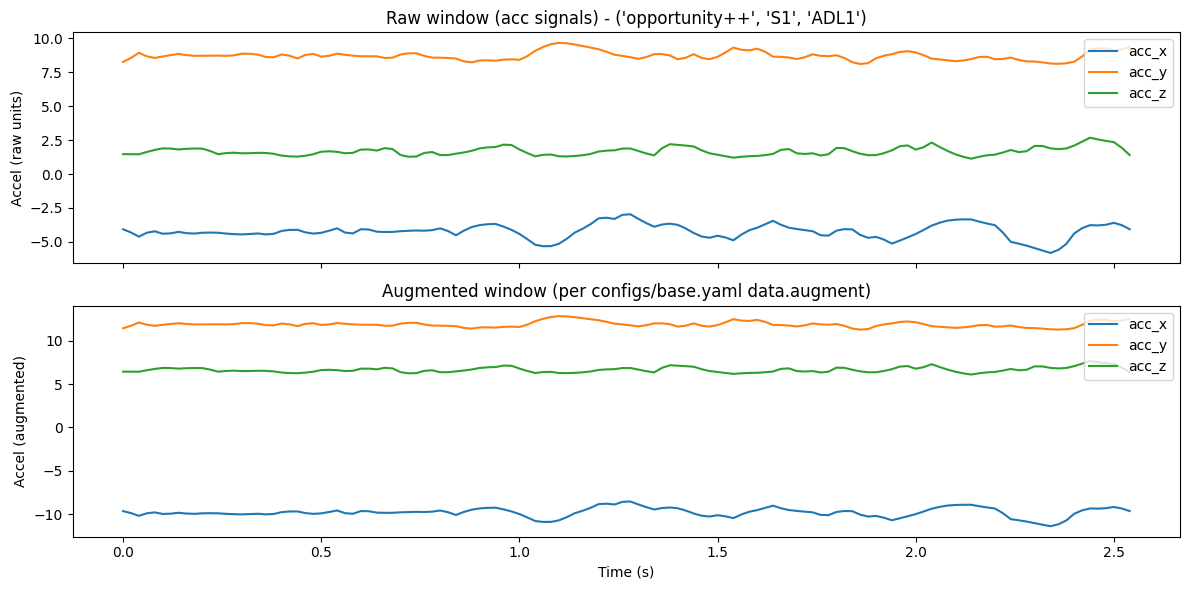

In [18]:
# Visualize raw vs augmented window (uses configs/base.yaml and imu_lm.data.augmentations.transform.apply_augment)
# This is fast: streams a single session and a single window.

import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import yaml

from imu_lm.data.augmentations.transform import apply_augment
from imu_lm.data.windowing import compute_T_and_hop


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(key, default)
        else:
            cur = getattr(cur, key, default)
    return cur if cur is not None else default


# Load config and dataset path
cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["data", "loading", "dataset_path"])

# Columns
sensor_cols = cfg_get(cfg, ["data", "loading", "sensor_columns"], [])
label_col = cfg_get(cfg, ["data", "loading", "label_column"], "global_activity_id")
time_col = cfg_get(cfg, ["data", "loading", "time_column"], None)
dataset_col = cfg_get(cfg, ["data", "loading", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "loading", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "loading", "session_column"], "session_id")

# Find a session key quickly (scan only key columns)
pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)
key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    ds_vals = batch[dataset_col].to_pylist()
    subj_vals = batch[subject_col].to_pylist()
    sess_vals = batch[session_col].to_pylist()
    if ds_vals:
        key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
        break
assert key is not None, "No sessions found in dataset"

# Fetch that session's rows (only needed columns)
cols = list(sensor_cols) + [label_col]
if time_col:
    cols.append(time_col)
cols.extend([dataset_col, subject_col, session_col])

filt = (
    (ds.field(dataset_col) == key[0])
    & (ds.field(subject_col) == key[1])
    & (ds.field(session_col) == key[2])
)
table = pa_ds.to_table(columns=cols, filter=filt)
df = table.to_pandas()

# Take first window
T, _ = compute_T_and_hop(cfg)
assert len(df) >= T, "Session shorter than one window"
X = df[sensor_cols].to_numpy(dtype=np.float32)
Xw = X[:T]

# Apply augmentations per config
X_aug = apply_augment(Xw.copy(), cfg)

# Plot
fs = 50.0
tr = np.arange(Xw.shape[0]) / fs
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(tr, Xw)
axes[0].set_title(f"Raw window (acc signals) - {key}")
axes[0].set_ylabel("Accel (raw units)")
axes[0].legend(sensor_cols, loc="upper right")

axes[1].plot(tr, X_aug)
axes[1].set_title("Augmented window (per configs/base.yaml data.augment)")
axes[1].set_ylabel("Accel (augmented)")
axes[1].legend(sensor_cols, loc="upper right")
axes[1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()


spec : (3, 65, 65) torch.float32 cpu
img  : (3, 65, 65) torch.float32 cpu


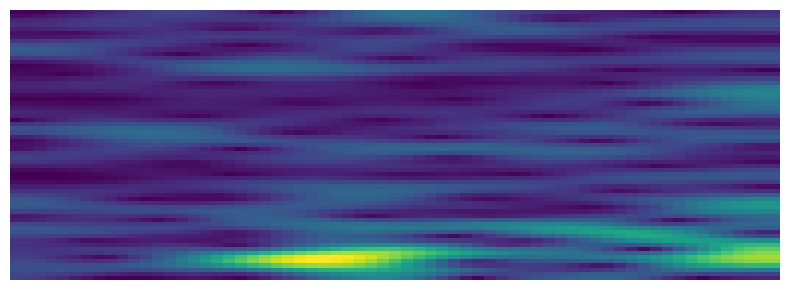

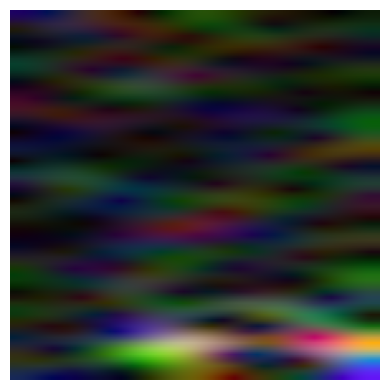

In [42]:
# # Visualize spectrogram for one IMU window (config-driven torch.stft)
# # - Streams one session quickly (no full index), takes first window.
# # - Uses data.augment.spectrogram knobs (n_fft, win_length, hop_length, center).
# # - If return_image=True in config, also shows the PNG produced by stft_encode.

# import numpy as np
# import matplotlib.pyplot as plt
# import pyarrow.dataset as ds
# import torch
# import yaml
# from IPython.display import Image, display

# from imu_lm.data.windowing import compute_T_and_hop
# from imu_lm.data.augmentations.spectrogram import stft_encode


# def cfg_get(cfg, path, default=None):
#     cur = cfg
#     for key in path:
#         if cur is None:
#             return default
#         if isinstance(cur, dict):
#             cur = cur.get(key, default)
#         else:
#             cur = getattr(cur, key, default)
#     return cur if cur is not None else default


# # Load config and dataset path
# cfg = yaml.safe_load(open("configs/base.yaml", "r"))
# parquet_path = cfg_get(cfg, ["data", "loading", "dataset_path"])

# sensor_cols = cfg_get(cfg, ["data", "loading", "sensor_columns"], [])
# label_col = cfg_get(cfg, ["data", "loading", "label_column"], "global_activity_id")
# time_col = cfg_get(cfg, ["data", "loading", "time_column"], None)
# dataset_col = cfg_get(cfg, ["data", "loading", "dataset_column"], "dataset")
# subject_col = cfg_get(cfg, ["data", "loading", "subject_column"], "subject_id")
# session_col = cfg_get(cfg, ["data", "loading", "session_column"], "session_id")

# # Find a session key quickly (scan only key columns)
# pa_ds = ds.dataset(parquet_path, format="parquet")
# key_cols = [dataset_col, subject_col, session_col]
# scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)
# key = None
# for batch in scanner.to_batches():
#     if len(batch) == 0:
#         continue
#     ds_vals = batch[dataset_col].to_pylist()
#     subj_vals = batch[subject_col].to_pylist()
#     sess_vals = batch[session_col].to_pylist()
#     if ds_vals:
#         key = (str(ds_vals[0]), str(subj_vals[0]), str(sess_vals[0]))
#         break
# assert key is not None, "No sessions found in dataset"

# # Fetch that session's rows (only needed columns)
# cols = list(sensor_cols) + [label_col]
# if time_col:
#     cols.append(time_col)
# cols.extend([dataset_col, subject_col, session_col])

# filt = (
#     (ds.field(dataset_col) == key[0])
#     & (ds.field(subject_col) == key[1])
#     & (ds.field(session_col) == key[2])
# )
# table = pa_ds.to_table(columns=cols, filter=filt)
# df = table.to_pandas()

# # Take first window
# T, _ = compute_T_and_hop(cfg)
# assert len(df) >= T, "Session shorter than one window"
# X = df[sensor_cols].to_numpy(dtype=np.float32)
# Xw = X[:T]

# from imu_lm.data.augmentations.preprocess import preprocess_window

# # Xw is [T, C] numpy from your parquet window
# Xproc = preprocess_window(Xw.copy(), cfg)      # -> [C, T] (per your preprocess code)
# assert Xproc is not None, "Window dropped by preprocessing"

# x_ct = torch.from_numpy(np.ascontiguousarray(Xproc)).float()  # [C, T]
# spec_out = stft_encode(x_ct, cfg)
# if isinstance(spec_out, tuple):
#     spec, png_bytes = spec_out
# else:
#     spec, png_bytes = spec_out, None

# # Plot first channel spectrogram (magnitude)
# spec_np = spec[0].cpu().numpy()
# fig, ax = plt.subplots(figsize=(8, 3))
# ax.imshow(spec_np, aspect="auto", origin="lower")
# ax.axis("off")
# plt.tight_layout()
# plt.show()

# # Show PNG if available (axes-free rendering from stft_encode)
# if png_bytes is not None:
#     display(Image(png_bytes))

import numpy as np
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import torch
import yaml

from imu_lm.data.windowing import compute_T_and_hop
from imu_lm.data.augmentations.spectrogram import stft_encode
from imu_lm.data.augmentations.preprocess import preprocess_window
import torch.nn.functional as F
from imu_lm.data.augmentations.transform import apply_augment
 


def cfg_get(cfg, path, default=None):
    cur = cfg
    for key in path:
        if cur is None:
            return default
        cur = cur.get(key, default) if isinstance(cur, dict) else getattr(cur, key, default)
    return cur if cur is not None else default


cfg = yaml.safe_load(open("configs/base.yaml", "r"))
parquet_path = cfg_get(cfg, ["paths", "dataset_path"])

sensor_cols  = cfg_get(cfg, ["data", "sensor_columns"], [])
label_col    = cfg_get(cfg, ["data", "label_column"], "global_activity_id")
time_col     = cfg_get(cfg, ["data", "time_column"], None)
dataset_col  = cfg_get(cfg, ["data", "dataset_column"], "dataset")
subject_col  = cfg_get(cfg, ["data", "subject_column"], "subject_id")
session_col  = cfg_get(cfg, ["data", "session_column"], "session_id")

pa_ds = ds.dataset(parquet_path, format="parquet")
key_cols = [dataset_col, subject_col, session_col]
scanner = pa_ds.scanner(columns=key_cols, batch_size=100_000)

key = None
for batch in scanner.to_batches():
    if len(batch) == 0:
        continue
    key = (str(batch[dataset_col][0].as_py()),
           str(batch[subject_col][0].as_py()),
           str(batch[session_col][0].as_py()))
    break
assert key is not None

cols = list(sensor_cols) + [label_col] + [dataset_col, subject_col, session_col]
if time_col:
    cols.append(time_col)

filt = (
    (ds.field(dataset_col) == key[0]) &
    (ds.field(subject_col) == key[1]) &
    (ds.field(session_col) == key[2])
)

df = pa_ds.to_table(columns=cols, filter=filt).to_pandas()

T, _ = compute_T_and_hop(cfg)
Xw = df[sensor_cols].to_numpy(np.float32)[:T]

Xproc = preprocess_window(Xw.copy(), cfg)   # [C,T]
assert Xproc is not None

 
# Apply augmentations (expects [T, C], returns [T, C])
Xproc = apply_augment(Xproc.T, cfg).T       # <-- ADD THIS LINE
 


x_ct = torch.from_numpy(np.ascontiguousarray(Xproc)).float()

out = stft_encode(x_ct, cfg)


if isinstance(out, tuple):
    spec, img = out          # spec: [C,F,TT], img: [3,F,TT]
    print("spec :", tuple(spec.shape), spec.dtype, spec.device)   # [C,F,TT]
    print("img  :", tuple(img.shape), img.dtype, img.device)      # [3,F,TT
else:
    spec, img = out, None

# Visualize spec channel 0
plt.figure(figsize=(8, 3))
plt.imshow(spec[1].cpu().numpy(), aspect="auto", origin="lower")
plt.axis("off")
plt.tight_layout()
plt.show()


# Visualize image tensor if present
if img is not None:
    img_resized = F.interpolate(img.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False)
    img_resized = img_resized.squeeze(0)  # [3,224,224]
 
    plt.figure(figsize=(4, 4))
    plt.imshow(img_resized.permute(1, 2, 0).cpu().numpy(), aspect="auto", origin="lower")
    plt.axis("off")
    plt.tight_layout()
    plt.show()




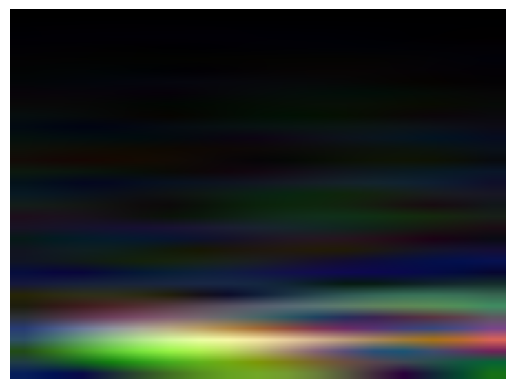

img_resized stats: 1.8196153632743517e-06 0.9975793957710266 0.1295774132013321
img_hf stats: -2.1171891689300537 2.417764902114868 -1.412224531173706


In [3]:
hf_mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
hf_std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
 
img_resized = F.interpolate(img.unsqueeze(0), size=(224,224), mode="bilinear", align_corners=False).squeeze(0)  # [3,224,224]
img_hf = (img_resized - hf_mean) / hf_std  # normalized
 
# for visualization, unnormalize back to 0-1
vis = (img_hf * hf_std + hf_mean).permute(1,2,0).cpu().numpy()
plt.imshow(vis, aspect="auto", origin="lower"); plt.axis("off"); plt.show()
 
print("img_resized stats:", img_resized.min().item(), img_resized.max().item(), img_resized.mean().item())
print("img_hf stats:", img_hf.min().item(), img_hf.max().item(), img_hf.mean().item())

In [7]:
import yaml
import pyarrow.dataset as ds

# load base config
cfg = yaml.safe_load(open("configs/base.yaml"))
parquet_path = cfg["data"]["loading"]["dataset_path"]
dataset_col = cfg["data"]["loading"]["dataset_column"]

print("parquet:", parquet_path)
dset = ds.dataset(parquet_path, format="parquet")

# list dataset names and counts
table = dset.to_table(columns=[dataset_col])
vals = table[dataset_col].to_pylist()
from collections import Counter
cnt = Counter(vals)
print("unique datasets:", len(cnt))
for name, c in cnt.most_common():
    print(f"{name}: {c}")

parquet: /home/aidan/TransfHAR/imu_lm/data/data_drive/IMULM_master_dataset.parquet
unique datasets: 10
capture24: 699011946
ut_watch: 8146709
wisdm: 8045562
recofit: 7745018
wear: 3462973
prism: 3037272
pamap2: 1271041
samosa: 1204655
shoaib: 1170000
opportunity++: 985421


In [2]:
# FAST sanity check: uses NATIVE WindowDataset but with just ONE session
# Builds a minimal session index to avoid full parquet scan

import pandas as pd
import pyarrow.dataset as ds
import torch

from imu_lm.utils.helpers import load_yaml, cfg_get
from imu_lm.data.loaders import WindowDataset, collate_skip_none, _make_loader
from imu_lm.data.splits import SessionKey

cfg = load_yaml("configs/base.yaml")
# Uncomment to test spectrogram path:
# from imu_lm.utils.helpers import deep_update
# cfg = deep_update(cfg, load_yaml("configs/vit.yaml"))

parquet_path = cfg_get(cfg, ["paths", "dataset_path"])
dataset_col = cfg_get(cfg, ["data", "dataset_column"], "dataset")
subject_col = cfg_get(cfg, ["data", "subject_column"], "subject_id")
session_col = cfg_get(cfg, ["data", "session_column"], "session_id")
batch_size = int(cfg_get(cfg, ["data", "batch_size"], 256))

print("=== Finding one session via pyarrow (fast) ===")
pa_ds = ds.dataset(parquet_path, format="parquet")
scanner = pa_ds.scanner(columns=[dataset_col, subject_col, session_col], batch_size=10000)

# Find first session key
key = None
for batch in scanner.to_batches():
    if len(batch) > 0:
        key = SessionKey(
            dataset=str(batch[dataset_col][0].as_py()),
            subject_id=str(batch[subject_col][0].as_py()),
            session_id=str(batch[session_col][0].as_py()),
        )
        break

# Count rows in that session (fast filter)
filt = (
    (ds.field(dataset_col) == key.dataset) &
    (ds.field(subject_col) == key.subject_id) &
    (ds.field(session_col) == key.session_id)
)
n_rows = pa_ds.scanner(filter=filt).count_rows()
print(f"Session: {key}, n_rows={n_rows}")

# Build minimal session_index DataFrame (what build_session_index would return)
session_index = pd.DataFrame([{
    "dataset": key.dataset,
    "subject_id": key.subject_id,
    "session_id": key.session_id,
    "n_rows": n_rows,
    "gap_count": 0,
}])

# Use NATIVE WindowDataset with this minimal index
print("\n=== Creating native WindowDataset ===")
dataset = WindowDataset(
    parquet_path=parquet_path,
    session_index=session_index,
    session_keys=[key],
    cfg=cfg,
    split_name="sanity_check",
)
print(f"Windows in dataset: {len(dataset)}")

# Create native DataLoader (batch_size from config)
batch_size = min(batch_size, len(dataset))
loader = _make_loader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

# Get one batch using native collate
print(f"\n=== Fetching one batch (batch_size={batch_size} from config) ===")
batch = next(iter(loader))
if batch is None:
    print("Batch was None (all windows dropped)")
else:
    x, y = batch
    print(f"x.shape: {tuple(x.shape)}")
    print(f"x.dtype: {x.dtype}")
    print(f"y.shape: {tuple(y.shape)}")
    print(f"y.dtype: {y.dtype}")
    print(f"\nExpected 1D: [B, C, T]")
    print(f"Expected 2D: [B, 3, F, TT]")

=== Finding one session via pyarrow (fast) ===
Session: SessionKey(dataset='opportunity++', subject_id='S1', session_id='ADL1'), n_rows=69991

=== Creating native WindowDataset ===
Windows in dataset: 1092

=== Fetching one batch (batch_size=128 from config) ===
x.shape: (128, 3, 128)
x.dtype: torch.float32
y.shape: (128,)
y.dtype: torch.int64

Expected 1D: [B, C, T]
Expected 2D: [B, 3, F, TT]


In [1]:
# Quick check: SAMoSA dataset — unique labels & available sensor columns
# + Per-dataset gyroscope availability check
import yaml
import pyarrow.dataset as ds

cfg = yaml.safe_load(open("configs/base.yaml"))
parquet_path = cfg["paths"]["dataset_path"]
dataset_col = cfg["data"]["dataset_column"]
label_col = cfg["data"]["label_column"]  # dataset_activity_id

dset = ds.dataset(parquet_path, format="parquet")

# --- SAMoSA label analysis ---
filt = ds.field(dataset_col) == "samosa"
table = dset.to_table(filter=filt)
df = table.to_pandas()

print(f"SAMoSA rows: {len(df):,}")
print(f"\nAll columns in parquet: {sorted(df.columns.tolist())}")

unique_labels = sorted(df[label_col].dropna().unique().tolist())
print(f"\nUnique '{label_col}' values ({len(unique_labels)} classes):")
for lbl in unique_labels:
    count = (df[label_col] == lbl).sum()
    print(f"  {lbl}: {count:,} rows")

name_col = "dataset_activity_label"
if name_col in df.columns:
    print(f"\nLabel name mapping ({name_col}):")
    pairs = df[[label_col, name_col]].drop_duplicates().sort_values(label_col)
    for _, row in pairs.iterrows():
        print(f"  {row[label_col]} -> {row[name_col]}")

# --- Per-dataset gyroscope availability ---
gyro_cols = [c for c in dset.schema.names if c.startswith("gyro_")]
print(f"\n{'='*50}")
print(f"Gyro columns in schema: {gyro_cols}")
print(f"{'='*50}")

datasets_table = dset.to_table(columns=[dataset_col])
dataset_names = sorted(set(datasets_table[dataset_col].to_pylist()))

for ds_name in dataset_names:
    filt = ds.field(dataset_col) == ds_name
    sample = dset.to_table(columns=gyro_cols, filter=filt).slice(0, 1).to_pandas()
    if gyro_cols and len(sample) > 0:
        has_gyro = sample[gyro_cols].notna().any(axis=1).iloc[0]
    else:
        has_gyro = False
    print(f"Dataset: {ds_name:20s} Gyro: {'Yes' if has_gyro else 'No'}")

SAMoSA rows: 1,204,655

All columns in parquet: ['acc_x', 'acc_y', 'acc_z', 'dataset', 'dataset_activity_id', 'dataset_activity_label', 'global_activity_id', 'global_activity_label', 'gyro_x', 'gyro_y', 'gyro_z', 'session_id', 'subject_id', 'timestamp_ns']

Unique 'dataset_activity_id' values (27 classes):
  0: 56,081 rows
  1: 44,387 rows
  2: 47,522 rows
  3: 46,573 rows
  4: 41,086 rows
  5: 29,524 rows
  6: 19,781 rows
  7: 22,652 rows
  8: 45,767 rows
  9: 50,402 rows
  10: 43,558 rows
  11: 16,533 rows
  12: 37,372 rows
  13: 74,895 rows
  14: 121,698 rows
  15: 32,234 rows
  16: 44,797 rows
  17: 41,256 rows
  18: 47,499 rows
  19: 49,177 rows
  20: 22,927 rows
  21: 50,148 rows
  22: 16,849 rows
  23: 51,000 rows
  24: 48,863 rows
  25: 48,715 rows
  26: 53,359 rows

Label name mapping (dataset_activity_label):
  0 -> Alarm_clock
  1 -> Blender_in_use
  2 -> Brushing_hair
  3 -> Chopping
  4 -> Clapping
  5 -> Coughing
  6 -> Drill in use
  7 -> Drinking
  8 -> Grating
  9 -> H